# Fine-Tuning

## Escolha do Dataset

O Dataset proposto para ser utilizado no tech challange é o **The AmazonTitles-1.3MM**. Este consiste em consultas textuais reais de usuários e títulos associados de produtos relevantes encontrados na Amazon e suas descrições, medidos por ações implícitas ou explícitas dos 
usuários.

Pelo tamanho do dataset, não sera possível disponibiliza-lo de forma direta aqui. Para executar esse processo, deve-se baixar o arquivo no [link](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view) que foi fornecido pelo Tech Challange, extrair e inserir o "trn.json" na raiz do projeto.

## Preparação do Dataset

### Carregamento

Utilização do arquivo "trn.json" do Dataset proposto, apenas com as colunas "title" e "content" as quais serão utilizadas posteriormente no fine tuning do modelo de LLM, de forma que responda as informações da descrição do produto com base em pergunta sobre o título.

In [ ]:
! pip install pandas

In [1]:
import pandas as pd

# Carregando o arquivo JSONL inteiro
file_path = './trn.json'
df = pd.read_json(file_path, lines=True)

# Selecionando apenas as colunas desejadas
colunas_desejadas = ['title', 'content']
df_selecionado = df[colunas_desejadas]

# Exibindo as primeiras linhas para verificar o resultado
print(df_selecionado.head())


                                               title  \
0                        Girls Ballet Tutu Neon Pink   
1                           Adult Ballet Tutu Yellow   
2  The Way Things Work: An Illustrated Encycloped...   
3                                      Mog's Kittens   
4                              Misty of Chincoteague   

                                             content  
0  High quality 3 layer ballet tutu. 12 inches in...  
1                                                     
2                                                     
3  Judith Kerr&#8217;s best&#8211;selling adventu...  
4                                                     


In [2]:
# Verificando o número de linhas
df_selecionado.shape[0]

2248619

### Limpeza e pré-processamento

In [3]:
import numpy as np

# Substituindo valores vazios ("") por NaN
df_selecionado.replace("", np.nan, inplace=True)

# Removendo linhas com valores nulos
df_selecionado.dropna(inplace=True)

# Removendo linhas duplicadas
df_selecionado.drop_duplicates(inplace=True)

df_selecionado.shape[0]


C:\Users\leona\AppData\Local\Temp\ipykernel_16932\2741903638.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado.replace("", np.nan, inplace=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_16932\2741903638.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado.dropna(inplace=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_16932\2741903638.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado

1367131

vamos deixar o texto preparado para que esteja em um formato de pergunta, de forma que esteja simulando a pergunta do usuário para exemplificar no treinamento.

In [4]:
df_selecionado['formatted_title'] = df_selecionado['title'].apply(lambda x: f"What is product {x} on Amazon?")
df_selecionado

C:\Users\leona\AppData\Local\Temp\ipykernel_16932\1435188121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado['formatted_title'] = df_selecionado['title'].apply(lambda x: f"What is product {x} on Amazon?")


,title,content,formatted_title
0,Girls Ballet Tutu Neon Pink,High quality 3 layer ballet tutu. 12 inches in...,What is product Girls Ballet Tutu Neon Pink on...
3,Mog's Kittens,Judith Kerr&#8217;s best&#8211;selling adventu...,What is product Mog's Kittens on Amazon?
7,Girls Ballet Tutu Neon Blue,Dance tutu for girls ages 2-8 years. Perfect f...,What is product Girls Ballet Tutu Neon Blue on...
12,The Prophet,"In a distant, timeless place, a mysterious pro...",What is product The Prophet on Amazon?
13,Rightly Dividing the Word,--This text refers to thePaperbackedition.,What is product Rightly Dividing the Word on A...
...,...,...,...
2248608,[180 Days Warranty] ZeroLemon&reg; Samsung Gal...,Features:This is the World's highest capacity ...,What is product [180 Days Warranty] ZeroLemon&...
2248611,Teenage Mutant Ninja Turtles Donatello Wizard ...,"With a pointed bed sheet hat, robe decorated w...",What is product Teenage Mutant Ninja Turtles D...
2248612,~Shave Ready~ Shaving Straight Razor 6/8&quot;...,"Inside this amazing set is a 6/8"" round point ...",What is product ~Shave Ready~ Shaving Straight...
2248617,Cont Removable Paper Label,"Continuous Length Removable Paper Label 2-3/7""...",What is product Cont Removable Paper Label on...


Vamos fazer o mesmo para o content, mas nesse caso para incluir a referência de source para que possa ser utilizado na exemplificação de resposta no treinamento.

In [6]:
df_selecionado['formatted_content'] = df_selecionado['content'].apply(
    lambda x: f"{x}  \n***  \n**Source:** 'trn.json' file in dataset [The AmazonTitles-1.3MM](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view)"
)
df_selecionado


C:\Users\leona\AppData\Local\Temp\ipykernel_16932\3909518501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado['formatted_content'] = df_selecionado['content'].apply(


,title,content,formatted_title,formatted_content
0,Girls Ballet Tutu Neon Pink,High quality 3 layer ballet tutu. 12 inches in...,What is product Girls Ballet Tutu Neon Pink on...,High quality 3 layer ballet tutu. 12 inches in...
3,Mog's Kittens,Judith Kerr&#8217;s best&#8211;selling adventu...,What is product Mog's Kittens on Amazon?,Judith Kerr&#8217;s best&#8211;selling adventu...
7,Girls Ballet Tutu Neon Blue,Dance tutu for girls ages 2-8 years. Perfect f...,What is product Girls Ballet Tutu Neon Blue on...,Dance tutu for girls ages 2-8 years. Perfect f...
12,The Prophet,"In a distant, timeless place, a mysterious pro...",What is product The Prophet on Amazon?,"In a distant, timeless place, a mysterious pro..."
13,Rightly Dividing the Word,--This text refers to thePaperbackedition.,What is product Rightly Dividing the Word on A...,--This text refers to thePaperbackedition. \n...
...,...,...,...,...
2248608,[180 Days Warranty] ZeroLemon&reg; Samsung Gal...,Features:This is the World's highest capacity ...,What is product [180 Days Warranty] ZeroLemon&...,Features:This is the World's highest capacity ...
2248611,Teenage Mutant Ninja Turtles Donatello Wizard ...,"With a pointed bed sheet hat, robe decorated w...",What is product Teenage Mutant Ninja Turtles D...,"With a pointed bed sheet hat, robe decorated w..."
2248612,~Shave Ready~ Shaving Straight Razor 6/8&quot;...,"Inside this amazing set is a 6/8"" round point ...",What is product ~Shave Ready~ Shaving Straight...,"Inside this amazing set is a 6/8"" round point ..."
2248617,Cont Removable Paper Label,"Continuous Length Removable Paper Label 2-3/7""...",What is product Cont Removable Paper Label on...,"Continuous Length Removable Paper Label 2-3/7""..."


Para utilizar o fine tunning do Gemini, há algumas limitações como por exemplo:
- The maximum input size per example is 40,000 characters.
- The maximum output size per example is 5,000 characters.

Nesse sentido, é necessário tratar para que não receba exemplos que ultrapasse esses valores.

In [7]:
# Filtrando linhas com menos de 40.000 caracteres na coluna "title"
df_selecionado = df_selecionado[df_selecionado['formatted_title'].apply(lambda x: len(x) <= 40000)]

# Filtrando linhas com menos de 5.000 caracteres na coluna "content"
df_selecionado = df_selecionado[df_selecionado['formatted_content'].apply(lambda x: len(x) <= 5000)]

In [8]:
df_selecionado.shape[0]

1361217

A uma limitação do tamanho de dados de treinamento que pode ser passado para o fine tuning com a lib (max 400 MB) e também limitação referente ao numero de exemplos que podemos utilizar multiplicado pleo número de épocas (len(examples) * epoch_count < 250.000). 

Nesse sentido, vamos precisar reduzir o dataset.

Primeiro vamos verificar o tamanho do "arquivo" do dataset selecionado.

In [9]:
import sys

columns_for_training = ['formatted_title','formatted_content']
dataset_for_training_size = sys.getsizeof(df_selecionado[columns_for_training])
print(f"Tamanho atual do dataset: {dataset_for_training_size / (1024 * 1024)} MB")

Tamanho atual do dataset: 1196.5949487686157 MB


Remover primeiramente as linhas com base na quantidade de épocas exploradas, que consequentemente deve reduzir o tamanho em MB.

In [10]:
# Embaralhando o DataFrame
df_shuffled = df_selecionado.sample(frac=1, random_state=42).reset_index(drop=True)

**Calculando o limite permitido:**

In [11]:
epoch_count = 2

max_examples = 250000 // epoch_count
print(f"Pode-se usar até {max_examples} exemplos no dataset com {epoch_count} épocas.")

Pode-se usar até 125000 exemplos no dataset com 2 épocas.


**Reduzindo o Dataset:**

In [12]:
# Removendo as linhas excedentes
df_reduced = df_shuffled.iloc[:max_examples]

In [13]:
df_reduced.shape[0]

125000

In [14]:
new_size = sys.getsizeof(df_reduced[columns_for_training])
print(f"Tamanho reduzido do dataset: {new_size / (1024 * 1024)} MB")

Tamanho reduzido do dataset: 108.88786697387695 MB


**Caso fosse necessário diminuir o tamanho ainda mais:**

In [ ]:
# # Quantidade de linhas totais no dataset
# total_rows = len(df_reduced)

# # Tamanho médio por linha
# average_row_size = dataset_size / total_rows

# # Limite de tamanho em bytes (400 MB)
# max_size = 400 * 1024 * 1024  # 400 MB em bytes

# # Calculando quantas linhas precisamos para ficar abaixo de 400 MB
# target_rows = int(max_size / average_row_size)

# # Removendo as linhas excedentes
# df_reduced = df_reduced.iloc[:target_rows]

# # Verificando o novo tamanho
# new_size = sys.getsizeof(df_reduced)
# print(f"Tamanho reduzido do dataset: {new_size / (1024 * 1024)} MB")

In [15]:
# Salvando o DataFrame reduzido e formatado com sources em formato JSONL para melhor visualização dos dados finais
df_reduced.to_json('dataset_reduzido_com_sources_formatado.jsonl', orient='records', lines=True)

Vamos zipar o jsonl resumido, pois seu tamanho é grande para subir no repositório. Nesse sentido, o .jsonl será ignorado pelo git e o zip subirá para posterior descompressão se quiser ser analisado.

In [28]:
import zipfile
import os

# Name of the zip file to be created
zip_name = 'dataset_reduzido_com_sources_formatado_jsonl.zip'

# File or directory you want to zip
file_to_zip = 'dataset_reduzido_com_sources_formatado.jsonl'

# Create the zip file
with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Check if it's a directory
    if os.path.isdir(file_to_zip):
        # Add all files within the directory
        for folder, subfolders, files in os.walk(file_to_zip):
            for file in files:
                full_path = os.path.join(folder, file)
                zipf.write(full_path, os.path.relpath(full_path, file_to_zip))
    else:
        # Add a single file
        zipf.write(file_to_zip)


## Google AI Studio

In [ ]:
! pip install google-generativeai

### Chamada do Base (Foundation) Model

Antes de realizarmos o processo de execução do fine-tuning, testaremos com uma chamada no modelo base antes do treinamento, para que se obtenha uma base de análise após o fine-tuning.

#### Autenticação - OAuth

##### Pré requisitos

- Um Google Cloud Project
- Instalar o gcloud CLI localmente

Para realizar o fine tuning de um modelo base Gemini pelo Google AI Studio, é necessário fazer uma autenticação do tipo OAuth. 

Documentação de referência para OAuth: https://ai.google.dev/gemini-api/docs/oauth
 
_OAuth é apenas necessário para o fine tuning. Para a utilização do modelo fine tuned, pode utilizar API Key._

In [16]:
!gcloud auth application-default login \
    --client-id-file=client_secret.json \
    --scopes="https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.retriever,https://www.googleapis.com/auth/generative-language.tuning"

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=610173493762-cbik4ek8b40oo3hq52bk1hbam4egjr0r.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.retriever+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning&state=M7jeWiiYowAlPmSAeUMfWHiOi0CY7o&access_type=offline&code_challenge=8EZO2mu7cXMPz67qYPW5xUjMnjnD6bWfIfjWip09S5c&code_challenge_method=S256


Credentials saved to file: [C:\Users\leona\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).


In [17]:
! gcloud auth application-default print-access-token

ya29.a0AcM612yWd_WCQsy6TnloMfMRmqXSnHsXgCSCrC0dBU1wftTFAjQQdvvHCrrfvbzSluMma1Np_OO1pimHMDBV8p9duuO1A97eDj6XE3OTiT95KOW8w76J3Nsy3tyLlGnoxb5CspQeeYG4vUEbc3OnwThMIR8fZXzln-Q6lGFpaCgYKAT0SARASFQHGX2Mi_cZQFwLfGDNtwyoVHo1Q5g0175


In [ ]:
# ! pip install python-dotenv

In [56]:
# import os
import google.generativeai as genai
# from dotenv import load_dotenv

# load_dotenv()

# genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

base_model = "models/gemini-1.5-flash-001-tuning"
model_before = genai.GenerativeModel(
  model_name=base_model,
)

result_before = model_before.generate_content('What is product "5 Ft Turbo Tube Slide Yellow" on Amazon?')
result_before.text

'I do not have access to real-time information, including product details from online retailers like Amazon. To find information about the "5 Ft Turbo Tube Slide Yellow" on Amazon, you\'ll need to:\n\n1. **Go to Amazon\'s website.**\n2. **Search for "5 Ft Turbo Tube Slide Yellow".** This will likely bring up several results.\n3. **Look through the results** to find the specific product you\'re interested in. \n4. **Read the product description and customer reviews** to get more information about it.\n\nRemember, product availability and prices can change frequently. \n'

### Execução do Fine-Tuning

#### Criação do tuned model

##### Preparando dados de treinamento

O dataset foi limpado e pré processado acima. Porém para utilizar no trainamento é necessário passar as informações no formato de lista com "text_input" e "output", passando como exemplos de entrada e saída esperada.

In [19]:
training_data = df_reduced.apply(lambda row: {"text_input": row['formatted_title'], "output": row['formatted_content']}, axis=1).tolist()

##### Execução

In [23]:
id_model_tuning = "tech-challenge-fase3-with-source"

operation = genai.create_tuned_model(
    display_name="tech-challenge-fase3-with-source",
    id=id_model_tuning,
    source_model=base_model,
    epoch_count=epoch_count,
    batch_size=4,
    learning_rate=0.001,
    training_data=training_data,
)

##### Checando progresso do tuning

In [27]:
import time

for status in operation.wait_bar():
  time.sleep(10)

100%|██████████| 62500/62500 [00:04<00:00, 12808.69it/s]


##### Resultados tuning

Uma vez que o tuning esteja completo, podemos visualizar a curva de perda dos resultados do ajuste. A curva de perda mostra o quanto as previsões do modelo desviam das saídas ideais.

In [ ]:
! pip install seaborn

In [30]:
# model = operation.result()
# model

## Carregando informações do modelo finalizado (nome obtido pelo interface web)
model = genai.get_tuned_model(f"tunedModels/{id_model_tuning}")

In [31]:
model.state

<State.ACTIVE: 2>

<Axes: xlabel='epoch', ylabel='mean_loss'>

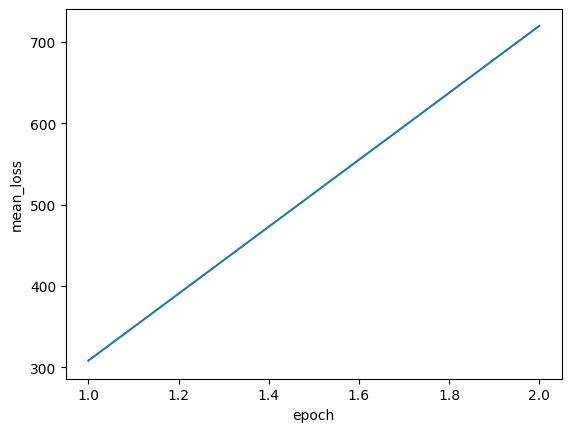

In [32]:
import pandas as pd
import seaborn as sns

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')

### Geração de respostas

In [35]:
model = genai.GenerativeModel(model_name=f"tunedModels/{id_model_tuning}")

In [57]:
result = model.generate_content('What is product "5 Ft Turbo Tube Slide Yellow" on Amazon?')
result.text

"Play on all day long with the slide from 5' turbo slide with a smooth glossy slide. The slides are made of a heavy gauge 3/4 in PVC material that resists impact from slides or rocks, and the slide is resistant to fading. Slides are sold as a complete kit and include all hardware, a PVC spray bottle, and instructions. All kits include slide, galvanized metal hardware, slide poles, end caps, slide stakes, and installation instructions. Slides do not include water hose attachments.  \n***  \n**Source:** 'trn.json' file in dataset [The AmazonTitles-1.3MM](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view)"

Agora, após o tuning no modelo, ele conseguiu responder a pergunta com informações do produto de fato!

No entanto ele foi "criativo" e colocou com dizeres diferente indo até além que o content original.

Comparando respostas antes, depois e conteúdo original:

Antes: 'I do not have access to real-time information, including product details from online retailers like Amazon. To find information about the "5 Ft Turbo Tube Slide Yellow" on Amazon, you\'ll need to:\n\n1. **Go to Amazon\'s website.**\n2. **Search for "5 Ft Turbo Tube Slide Yellow".** This will likely bring up several results.\n3. **Look through the results** to find the specific product you\'re interested in. \n4. **Read the product description and customer reviews** to get more information about it.\n\nRemember, product availability and prices can change frequently. \n'

Depois: "Play on all day long with the slide from 5' turbo slide with a smooth glossy slide. The slides are made of a heavy gauge 3/4 in PVC material that resists impact from slides or rocks, and the slide is resistant to fading. Slides are sold as a complete kit and include all hardware, a PVC spray bottle, and instructions. All kits include slide, galvanized metal hardware, slide poles, end caps, slide stakes, and installation instructions. Slides do not include water hose attachments.  \n***  \n**Source:** 'trn.json' file in dataset [The AmazonTitles-1.3MM](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view)"

Content Original: "The new 5' Turbo Tube Slide is full of turning twisting fun. This slide will take most play sets with a 5' deck to an entirely new level adding a new slide component to your child's fun and enjoyment. This thermo-formed HDPE slide comes with a lifetime warranty and will fit most 5' decks. Additional lumber purchase may be necessary depending on the configuration of your play set."

Caso queiramos que a resposta esteja mais próxima da original, podemos experimentar diminuindo a temperatura do modelo ao gerar conteúdo, de forma que ele fique menos "criativo".

In [77]:
result = model.generate_content('What is product "5 Ft Turbo Tube Slide Yellow" on Amazon?',generation_config={'temperature': 0})
result.text

"The 5 Ft Turbo Tube Slide Yellow is a great way to cool off on a hot summer day. The slide is made of durable PVC and is easy to assemble. It is also easy to clean and store.  \n***  \n**Source:** 'trn.json' file in dataset [The AmazonTitles-1.3MM](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view)"

**Depois com temperature 0:** '"The 5 Ft Turbo Tube Slide Yellow is a great way to cool off on a hot summer day. The slide is made of durable PVC and is easy to assemble. It is also easy to clean and store.  \n***  \n**Source:** 'trn.json' file in dataset [The AmazonTitles-1.3MM](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view)"'

**Content Original:** "The new 5' Turbo Tube Slide is full of turning twisting fun. This slide will take most play sets with a 5' deck to an entirely new level adding a new slide component to your child's fun and enjoyment. This thermo-formed HDPE slide comes with a lifetime warranty and will fit most 5' decks. Additional lumber purchase may be necessary depending on the configuration of your play set."

Explorarmos mais alguns outros produtos.

In [76]:
#Modelo base
result = model_before.generate_content('What is product "Dallas Cowboys Retractable Badge Reel Id Ticket Clip" on Amazon?')
print(f'Antes do tuning: {result.text}')

print('----------')

# Modelo tuned
result = model.generate_content('What is product "Dallas Cowboys Retractable Badge Reel Id Ticket Clip" on Amazon?')
print(f'Depois do tuning: {result.text}')

print('----------')

# Modelo tuned com temperature 0
result = model.generate_content('What is product "Dallas Cowboys Retractable Badge Reel Id Ticket Clip" on Amazon?',generation_config={'temperature': 0})
print(f'Depois do tuning com temperature 0: {result.text}')

print('----------')

# Content Original do dataset reduzido
print("Content Original: Team colored plastic reel. 1 round and has a team logo STICKER in the center. The Reel goes out 363 feet. It has a metal clip on the back and a snap clip to hold the ID or whatever. It could be used as a Ticket holder, Id Holder.")

Antes do tuning: I do not have access to real-time information, including product listings on Amazon. To get specific details about the "Dallas Cowboys Ret retractable Badge Reel Id Ticket Clip" on Amazon, I recommend you:

1. **Search for it directly on Amazon:** Go to the Amazon website and search for the exact product name. This will bring up the product listing, where you can see all the details, images, reviews, and pricing.

2. **Check the product description:** Once you find the product listing, read the description carefully. It should provide information about the features, materials, dimensions, and other important details of the badge reel.

3. **Look at the images:** The images provided on the product listing can give you a visual idea of what the badge reel looks like.

4. **Read customer reviews:** Customer reviews can be very helpful in understanding the quality, functionality, and overall satisfaction with the product.

I hope this helps! Let me know if you have any oth

In [75]:
#Modelo base
result = model_before.generate_content('What is product TOAKS Titanium 850ml Pot on Amazon?')
print(f"Antes do tuning: {result.text}")

print('----------')

# Modelo tuned
result = model.generate_content('What is product TOAKS Titanium 850ml Pot on Amazon?')
print(f"Depois do tuning: {result.text}")

print('----------')

# Modelo tuned com temperature 0
result = model.generate_content('What is product TOAKS Titanium 850ml Pot on Amazon?',generation_config={'temperature': 0})
print(f"Depois do tuning com temperature 0: {result.text}")

print('----------')

# Content Original do dataset reduzido
print("Content Original: This titanium pot has volume marking in ml and oz. It comes with a lid with lockable grip and a mesh storage sack.")

Antes do tuning: I do not have access to real-time information, including product details from online retailers like Amazon. To find information about the TOAKS Titanium 850ml Pot on Amazon, I recommend you visit the Amazon website directly. 

You can search for "TOAKS Titanium 850ml Pot" in the Amazon search bar. This will provide you with product details, reviews, images, and pricing information. 

----------
Depois do tuning: TOAKS Titanium 850ml Pot is made of titanium and has a 13.5 fl oz (390 ml) capacity. It is the ideal cook set for hikers and campers.  
***  
**Source:** 'trn.json' file in dataset [The AmazonTitles-1.3MM](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view)
----------
Depois do tuning com temperature 0: TOAKS Titanium 850ml Pot  
***  
**Source:** 'trn.json' file in dataset [The AmazonTitles-1.3MM](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view)
----------
Content Original: This titanium pot has volume marking in ml a